# Tweet Sentiment Analysis

The purpose of this notebook is to experiment with various basic natural language processing techniques and algorithms in order to try to classify the sentiment of tweets.

We will begin with importing a dataset of labelled tweets downloaded from Kaggle (https://www.kaggle.com/c/tweet-sentiment-extraction/data):

In [1]:
#Import main libraries
import pandas as pd
import numpy as np

In [2]:
#Import training and test datasets
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [3]:
#View first 5 entries of training dataset
train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
train.shape

(27481, 4)

Let's remove any rows that contain NaNs:

In [5]:
train[train.text.isnull()]

,textID,text,selected_text,sentiment
314,fdb77c3752,NaN,NaN,neutral


In [6]:
#remove nan entries
train = train[train.text.isnull()==False].reset_index()

In [7]:
train.shape

(27480, 5)

Each tweet in the training set has a 'sentiment' column, which classifies the tweet as positive, neutral or negative. Let's see what the distribution of these 3 classes looks like:

In [8]:
#Import pyplot
from matplotlib import pyplot as plt
%matplotlib inline

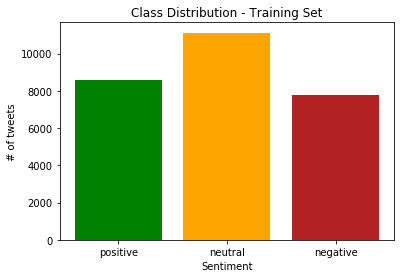

In [10]:
#Plot bar chart
plt.bar(x=[0,1,2], height=[len(train[train.sentiment=='positive']),len(train[train.sentiment=='neutral']),len(train[train.sentiment=='negative'])],color=['g','orange','firebrick'])
plt.xticks([0,1,2], ['positive','neutral','negative'])
plt.xlabel('Sentiment')
plt.ylabel('# of tweets')
plt.title('Class Distribution - Training Set')
plt.show()

It can be seen that the majority of tweets are labelled as neutral. For the purposes of this classification exercise it will be preferable to train our classifiers with a balanced dataset. For this reason we will rebalance the training set by randomly sampling the same number of samples from each class:

In [11]:
#randomly sample the same number of tweets from each of the three sentiment classes to obtain a balanced training set
import random
min_len = min([len(train[train.sentiment=='positive']),len(train[train.sentiment=='neutral']),len(train[train.sentiment=='negative'])])
pos_sample = random.sample(list(train[train.sentiment=='positive']['textID'].values), k=min_len)
neg_sample = random.sample(list(train[train.sentiment=='negative']['textID'].values), k=min_len)
neutral_sample = random.sample(list(train[train.sentiment=='neutral']['textID'].values), k=min_len)
sample_ids = pos_sample + neg_sample + neutral_sample
train = train[train['textID'].isin(sample_ids)]

Let's now also visualise the distribution of classes in the test set:

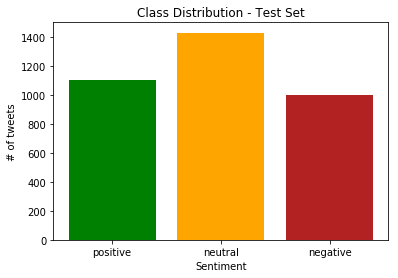

In [13]:
#Plot bar chart
plt.bar(x=[0,1,2], height=[len(test[test.sentiment=='positive']),len(test[test.sentiment=='neutral']),len(test[test.sentiment=='negative'])],color=['g','orange','firebrick'])
plt.xticks([0,1,2], ['positive','neutral','negative'])
plt.xlabel('Sentiment')
plt.ylabel('# of tweets')
plt.title('Class Distribution - Test Set')
plt.show()

### Text pre-processing ###

We will create a bag of words - a matrix where there is a row corresonding to each tweet and a column for each word in all the tweets, with 1s and 0s indicating whether a given tween contains a given word or not.   

But first let's consider a common issue with tweets. Twitter users tend to use repeated letters to emphasize words. For example one may write 'I looove this pizza' or 'This movie is sooo goood!'. We would ideally want our classifier to understand that 'looove' is the same as 'love' and 'sooo goood' is the same as 'so good'. Therefore, we need to pre-process the text of each tweet to remove duplicate letters. However, we must be careful because some English words actually have repeating letters - for example 'goood' must be interpreted as 'good' and not 'god'.

Note: some of the next cells are commented to avoid running computationally intensive calculations multiple times. In contrast, the following code has been ran once and the results were stored in a .pkl file so that they can be loaded every time the notebook is used.

In [14]:
# #create count_vector and fit it to the train data
# from sklearn.feature_extraction.text import CountVectorizer
# count_vector = CountVectorizer(lowercase=True, stop_words='english') #  exclude common words in English
# count_vector.fit(train['text'].get_values())

In [15]:
# #transform train to bag of words matrix
# train_matrix = count_vector.transform(train['text']).toarray()
# words_matrix =  pd.DataFrame(train_matrix, columns = count_vector.get_feature_names())

In [16]:
#functions to write and save object (so that we don't have to run computationally intensive algorithms every time the notebook is re-opened)
import pickle
def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

In [17]:
# #Algorithm to obtain a dictionary of non-existent words with repeated letters to correct English words
# import re
# all_words = words_matrix.columns.values
# word_dict = {}
# for word in all_words:
#     word_a = re.sub(r'(.)\1+', r'\1', word) #word with repeated characters reduced to 1 character
#     word_b = re.sub(r'(.)\1+', r'\1\1', word) #word with repeated characters reduced to 2 characters
    
#     #get count of each of the variations of the word in all sentences
#     count_ = words_matrix.word.sum(axis=0)
#     count_a = words_matrix[word_a].sum(axis=0) if word_a in all_words else 0
#     count_b = words_matrix[word_b].sum(axis=0) if word_b in all_words else 0
    
#     #determine which is the most common variation of the word
#     if count_ < count_a and count_a > count_b:
#         word_dict[word] = word_a
#     elif count_ < count_b and count_b > count_a:
#         word_dict[word] =  word_b
#     else:
#         word_dict[word] = word

# save_obj(word_dict, 'repeated_letters_dict')

In [18]:
word_dict = load_obj('repeated_letters_dict') #load pre-calculated dictionary

Let's test the dictionary for a few examples:

In [19]:
word_dict['goood']

'good'

In [20]:
word_dict['looove']

'love'

In [21]:
def remove_repeated_chars(sentence, word_dict):
    #function that translates all words in a text to their corresponding words according to a dictionary mapping
    import string
    sentence = sentence.translate(str.maketrans('', '', string.punctuation)) #remove punctuation from string 
    translated = []
    #translate each word using word_dict - i.e. convert non-existent words with repeating letters to correct words
    for x in list(sentence.split()):
        t = word_dict.get(x.lower(), x)
        translated.append(t)
    newphrase = ' '.join(translated)
    return newphrase

In [22]:
#store copy of training and test sets' text field with no repeating characters
train_text_norm = train.text.apply(lambda x: remove_repeated_chars(x, word_dict))
test_text_norm = test.text.apply(lambda x: remove_repeated_chars(x, word_dict))

Now that words with repeated characters have been fixed, we can create the training set's bag of words:

In [23]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector = CountVectorizer(lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector.fit(train_text_norm.get_values())

CountVectorizer(analyzer='word', binary=True, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words='english',
        strip_accents='ascii', token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [24]:
#transform train to bag of words matrix
train_matrix_norm = count_vector.transform(train_text_norm)
train_df_norm =  pd.DataFrame(train_matrix_norm.toarray(), columns = count_vector.get_feature_names())

In [25]:
#transform test to bag of words matrix, using count vectorizer fitted to train data
test_matrix_norm = count_vector.transform(test_text_norm)
test_df_norm =  pd.DataFrame(test_matrix_norm.toarray(), columns = count_vector.get_feature_names())

In [26]:
# # erase pre-normalisation bags of words from memory
# train_matrix= None
# words_matrix = None

We will do the same for the selected phrases in the training set (in case this is needed later):

In [27]:
#store copy of training set's selected_text field with no repeating characters
train_selected_norm = train.selected_text.apply(lambda x: remove_repeated_chars(x, word_dict))

In [28]:
#create count_vector and fit it to the train data
from sklearn.feature_extraction.text import CountVectorizer
count_vector_selected = CountVectorizer(lowercase=True, stop_words='english', strip_accents='ascii', binary=True)
count_vector_selected.fit(train_selected_norm.get_values())

#transform train to bag of words matrix
selected_matrix_norm = count_vector_selected.transform(train_selected_norm)
selected_df_norm =  pd.DataFrame(selected_matrix_norm.toarray(), columns = count_vector_selected.get_feature_names())

---

### Baseline Model ###

We will first test a simple model which is based on the balance between the count of words that are commonly encountered in positive sentiment tweets and words commonly used in negative sentiment tweets. If a given tweet contains more 'positive' words than 'negative' words it is classified as positive while if it contains more 'negative' words it is classified as negative. If there is the same number of 'positive' and 'negative' words (or the difference between the two counts is not greater than a pre-defined limit) then the tweet is classified as 'neutral'.

Let's first calculate some statistics about the frequency of occurrence of each word. We start by counting the number of samples that contain each word in the entire training dataset and in positive and negative samples seperately:

In [29]:
def get_word_stats(matrix, labels, thres_pct=0.5):
    #function that calculates the frequency of occcurence of words in positive and negative tweets
    #thres_pct: minimum percentage of occurence in a particular class for word to be retained
    
    #Count total occurences of each word
    total_freq = matrix.astype(bool).sum(axis=0).sort_values(ascending=False)
    
    #Count occurences of each word in positive and negative sentiment samples
    matrix['sentiment'] = labels    #add label column to word_matrix
    positive_freq = matrix[matrix.sentiment == 'positive'].iloc[:,:-1].astype(bool).sum(axis=0).sort_values(ascending=False)
    negative_freq = matrix[matrix.sentiment == 'negative'].iloc[:,:-1].astype(bool).sum(axis=0).sort_values(ascending=False)
    
    #Concatenate frequency counts into a single dataframe
    words_stats = pd.concat([total_freq, positive_freq.reindex(total_freq.index), negative_freq.reindex(total_freq.index)], axis=1)
    words_stats = words_stats.rename(columns={0: 'total_count', 1: 'pos_count', 2: 'neg_count'})
    
    #Calculate percentage of phrases that contain each word that have pos or neg sentiment
    words_stats['pos_pct'] = words_stats['pos_count']/words_stats['total_count']
    words_stats['neg_pct'] = words_stats['neg_count']/words_stats['total_count']
    
    #Remove words that do not have a particular class (pos or neg) mainly associated with them
    words_stats_reduced = words_stats[(words_stats.pos_pct>=thres_pct)|(words_stats.neg_pct>=thres_pct)]
    
    #Store words that appear frequently in positive or negative tweets
    pos_words = words_stats_reduced[words_stats_reduced.pos_pct>words_stats_reduced.neg_pct].index.values
    neg_words = words_stats_reduced[words_stats_reduced.pos_pct<words_stats_reduced.neg_pct].index.values
    
    return words_stats_reduced, pos_words, neg_words

In [31]:
# calculate word statistics
# word_stats, pos_words, neg_words = get_word_stats(train_df_norm, train.sentiment, thres_pct=0.5)

# save calculated stats to .pkl files in order to avoid having to run the above calculation every time the notebook is restarted 
# save_obj(word_stats, 'word_stats')
# save_obj(pos_words, 'pos_words')
# save_obj(neg_words, 'neg_words')

In [32]:
#load pre-calculated stats and pos & neg words
word_stats = load_obj('word_stats')
pos_words = load_obj('pos_words')
neg_words = load_obj('neg_words')

Let's see some of the most common words appearing in positive and negative sentiment tweets. We will start with the most positive words:

In [33]:
word_stats[word_stats.pos_pct>word_stats.neg_pct].sort_values('pos_count',ascending=False).head(10)

,total_count,pos_count,neg_count,pos_pct,neg_pct
day,1924,1141,308,0.593035,0.160083
good,1507,1018,198,0.675514,0.131387
love,1106,861,47,0.778481,0.042495
happy,953,817,43,0.857293,0.045121
mothers,636,555,13,0.872642,0.020440
thanks,655,550,19,0.839695,0.029008
great,599,467,33,0.779633,0.055092
hope,580,389,52,0.670690,0.089655
fun,515,337,68,0.654369,0.132039
nice,424,329,29,0.775943,0.068396


... and continue with the most negative words:

In [34]:
word_stats[word_stats.neg_pct>word_stats.pos_pct].sort_values('neg_count',ascending=False).head(10)

,total_count,pos_count,neg_count,pos_pct,neg_pct
miss,600,50,414,0.083333,0.690000
sad,469,6,384,0.012793,0.818763
sorry,470,21,336,0.044681,0.714894
bad,464,46,291,0.099138,0.627155
feel,515,109,283,0.211650,0.549515
hate,316,7,255,0.022152,0.806962
sick,252,11,196,0.043651,0.777778
sucks,207,2,177,0.009662,0.855072
tired,257,20,172,0.077821,0.669261
ugh,217,15,165,0.069124,0.760369


An additional useful statistic - the number of words in each text:

In [35]:
train_text_len = train.text.apply(lambda x: len(x.split()))
test_text_len = test.text.apply(lambda x: len(x.split()))

We now create a function for the baseline model described above:

In [36]:
def intersection(list1, list2): 
    return list(set(list1) & set(list2)) 

def baseline_classifier(matrix, text_len, pos_words, neg_words, limit=0, show_metrics=False, plot_confusion=False, correct_labels=None):
    #Remove words that appear in pos_words or neg_word but not in the texts to be classified
    pos_words = intersection(pos_words, matrix.columns.values)
    neg_words = intersection(neg_words, matrix.columns.values)
    #Calculate balance of 'positive' and 'negative' words in each text
    words_balance = pd.DataFrame(matrix[pos_words].sum(axis=1)-matrix[neg_words].sum(axis=1)).rename(columns={0:'balance'})
    #Calculate balance of 'positive' and 'negative' words as a percentage of the total number of words in the text
    words_balance['len'] = text_len #add total lenght of the text to words_balance
    words_balance['balance_pct'] = words_balance['balance']/words_balance['len'] #calculate percentage
    
    #Classify text based on balance. If abs(balance_pct)<limit then 'neutral'
    pred = words_balance.balance_pct.apply(lambda x: 'positive' if x>limit else ('negative' if x<-limit else 'neutral')).values
    #Calculate probability that text is in predicted class
    prob = words_balance.balance_pct.apply(lambda x: abs(x) if abs(x)>limit else 1-abs(x))
    
    if show_metrics and correct_labels is not None:
        from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
        print('Results')
        print('Accuracy score: ', format(accuracy_score(correct_labels, pred)))
        print('Precision score: ', format(precision_score(correct_labels, pred,average=None)))
        print('Recall score: ', format(recall_score(correct_labels, pred,average=None)))
        print('F1 score: ', format(f1_score(correct_labels, pred,average=None)))
    
    if plot_confusion and correct_labels is not None:
        from sklearn.metrics import confusion_matrix
        import seaborn as sns

        #Calculate confusion matrix
        cm = confusion_matrix(correct_labels, pred, ['positive','neutral','negative'])
        
        #Plot confusion matrix heatmap
        ax= plt.subplot()
        sns.heatmap(cm, annot=True, ax = ax)
        ax.set_xlabel('Predicted labels')
        ax.set_ylabel('True labels')
        ax.set_title('Confusion Matrix') 
        ax.xaxis.set_ticklabels(['positive','neutral','negative'])
        ax.yaxis.set_ticklabels(['positive','neutral','negative'])
        plt.show()
        
    
    return pred, prob

**Baseline Model using full text**

Run on training set with limit=0 (i.e. if n_pos>n_neg then 'positive'):

Results
Accuracy score:  0.7433406113537118
Precision score:  [0.75558167 0.79406769 0.69983211]
Recall score:  [0.82637193 0.54664028 0.9228618 ]
F1 score:  [0.78939292 0.64752264 0.7960199 ]


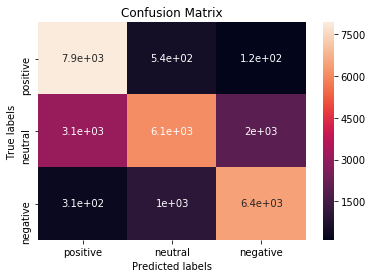

In [60]:
train_pred, prob = baseline_classifier(train_df_norm,train_text_len,pos_words,neg_words,limit=0,show_metrics=True,plot_confusion=True,correct_labels=train.sentiment.values)

Run on training set with limit=0.1 (i.e. if (n_pos-n_neg)/len > 0.1 then 'positive'):

Results
Accuracy score:  0.7599344978165938
Precision score:  [0.869272   0.67603839 0.81816007]
Recall score:  [0.64606092 0.81110012 0.79690049]
F1 score:  [0.74122678 0.73743611 0.80739035]


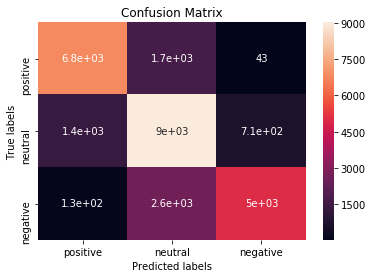

In [66]:
train_pred, prob = baseline_classifier(train_df_norm,train_text_len,pos_words,neg_words,limit=0.1,show_metrics=True,plot_confusion=True,correct_labels=train.sentiment.values)

While recall improves for 'neutral' when lim>0, it drops for 'positive' and 'negative' tweets.

Run on test set with limit=0:

Results
Accuracy score:  0.6120543293718166
Precision score:  [0.62085308 0.61137441 0.60603933]
Recall score:  [0.65434565 0.45104895 0.7824116 ]
F1 score:  [0.63715953 0.51911469 0.68302335]


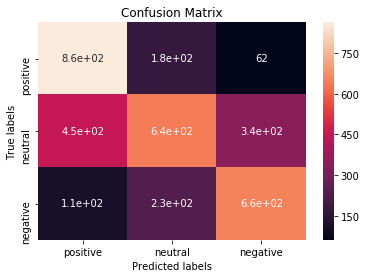

In [67]:
test_pred, prob = baseline_classifier(test_df_norm,test_text_len,pos_words,neg_words,limit=0,show_metrics=True,plot_confusion=True,correct_labels=test.sentiment.values)

**Baseline Model using selected_text**

We will now try training the baseline classifier with the selected_text from the training set instead of the full text of each document. This will help to only identify words that are truely associated with a given sentiment.

In [43]:
# run word stats calculator on selected text only:
# word_stats_selected, pos_words_selected, neg_words_selected = get_word_stats(selected_df_norm, train.sentiment, thres_pct=0.5)
# save_obj(word_stats_selected, 'word_stats_selected')
# save_obj(pos_words_selected, 'pos_words_selected')
# save_obj(neg_words_selected, 'neg_words_selected')

In [34]:
#load pre-calculated stats and pos & neg words
word_stats_selected = load_obj('word_stats_selected')
pos_words_selected = load_obj('pos_words_selected')
neg_words_selected = load_obj('neg_words_selected')

Results
Accuracy score:  0.6997736276174307
Precision score:  [0.70238095 0.65743243 0.75309735]
Recall score:  [0.64835165 0.68041958 0.77153218]
F1 score:  [0.67428571 0.66872852 0.76220331]


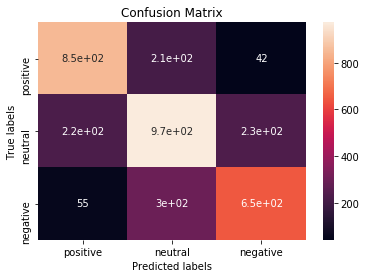

In [35]:
test_pred,prob = baseline_classifier(test_df_norm,test_text_len,pos_words_selected,neg_words_selected,limit=0,show_metrics=True,plot_confusion=True,correct_labels=test.sentiment.values)

As expected, the performance is indeed improved when we only focus on the words in the selected_text field. However, the selected_text field will not be available for new unlabeled tweets, therefore this model is not really useful.

---

### Training and evaluation of different Machine Learning models ###

Now that a basic, simple approach has been tested, we will try to use some more advanced classification algorithms and see how they compare to the results obtained above.

We will be using the pre-processed text that was obtained above:

In [29]:
# Store training and test datasets and the corresponding labels seperately
x_train = train_text_norm
x_test = test_text_norm

y_train = train.sentiment.values
y_test = test.sentiment.values

In [30]:
#Split training data into a training and a validation set (for calculating ensemble model's weights)
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train,test_size=0.1)

In [31]:
print('Train Set: {} samples'.format(x_train.shape[0]))
print('Test Set: {} samples'.format(x_test.shape[0]))
print('Validation Set: {} samples'.format(x_valid.shape[0]))

Train Set: 24732 samples
Test Set: 3534 samples
Validation Set: 2748 samples


In [32]:
# Transform into bags of words
x_train_bow = count_vector.transform(x_train)
x_test_bow = count_vector.transform(x_test)
x_valid_bow = count_vector.transform(x_valid)

**Model pipeline**

Let's create pipeline to test the performance of different machine learning models:

In [46]:
#encode training labels to an integer format that is interpretable by all sklearn classification models
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le = le.fit(train.sentiment.values.astype(str))

In [87]:
def run_model(model, model_name, train_data, train_labels, test_data, test_labels, label_encoder, tf_idf=False):
    #model pipeline function
    
    if tf_idf:
        from sklearn.feature_extraction.text import TfidfTransformer
        tfidf_transformer = TfidfTransformer()
        tfidf_transformer = tfidf_transformer.fit(train_data)
        train_data = tfidf_transformer.transform(train_data)
        test_data = tfidf_transformer.transform(test_data)
    
    train_labels_encoded = label_encoder.transform(train_labels.astype(str))
              
    #Fit model to training data
    model.fit(train_data, train_labels_encoded)
    
    #Test model's performance on training data
    train_pred = model.predict(train_data)
    train_pred = le.inverse_transform(train_pred)
    
    #Test model's performance on test data
    test_pred = model.predict(test_data) 
    test_pred = le.inverse_transform(test_pred)
    
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
    #Prin performance metrics
    print(model_name)
    print()
    print('Results on training set:')
    print('Accuracy score: ', format(accuracy_score(train_labels, train_pred)))
    print('Precision score: ', format(precision_score(train_labels, train_pred,average=None)))
    print('Recall score: ', format(recall_score(train_labels, train_pred,average=None)))
    print('F1 score: ', format(f1_score(train_labels, train_pred,average=None)))
    print('---------------------------------------------------------------------')
    print('Results on test set:')
    print('Accuracy score: ', format(accuracy_score(test_labels, test_pred)))
    print('Precision score: ', format(precision_score(test_labels, test_pred,average=None)))
    print('Recall score: ', format(recall_score(test_labels, test_pred,average=None)))
    print('F1 score: ', format(f1_score(test_labels, test_pred,average=None)))
    print('---------------------------------------------------------------------')
    
    #Plot confusion matrix for test set
    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(test_labels, test_pred, ['positive','neutral','negative'])

    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix - Test Set') 
    ax.xaxis.set_ticklabels(le.inverse_transform([0,1,2]))
    ax.yaxis.set_ticklabels(le.inverse_transform([0,1,2]))
    plt.show()
    
    return train_pred, test_pred, model, accuracy_score(test_labels,test_pred)

Import and specify the models to be tested:

In [88]:
from sklearn.naive_bayes import MultinomialNB, BernoulliNB, GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, BaggingClassifier, RandomForestClassifier

models = dict()

models['Multinomial Naive Bayes'] = MultinomialNB()
models['Bernoulli Naive Bayes'] = BernoulliNB()
models['Gaussian Naive Bayes'] = GaussianNB()
models['Logistic Regression'] = LogisticRegression(random_state=42, multi_class='auto')
models['KNN'] = KNeighborsClassifier(n_neighbors=5)
models['Decision Tree'] = DecisionTreeClassifier(random_state=42)
models['Bagging'] = BaggingClassifier(n_estimators=50 ,random_state=42)


This pipeline function will now be used in order to evaluate the performance of a set of algorithms on the training and test sets:

**Naive Bayes**

Multinomial Naive Bayes

Results on training set:
Accuracy score:  0.8488193433608281
Precision score:  [0.88264437 0.81941416 0.86069394]
Recall score:  [0.8092264  0.86595873 0.86281635]
F1 score:  [0.84434242 0.84204374 0.86175384]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6598754951895869
Precision score:  [0.68082664 0.60172096 0.73359073]
Recall score:  [0.59240759 0.68461538 0.68902992]
F1 score:  [0.63354701 0.64049722 0.71061244]
---------------------------------------------------------------------


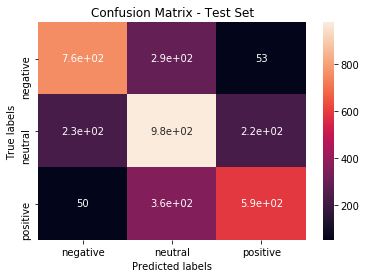

In [99]:
train_pred, test_pred, m_nb_model, m_nb_test_accuracy = run_model(models['Multinomial Naive Bayes'],'Multinomial Naive Bayes',x_train_bow,y_train,x_test_bow,y_test,le,tf_idf=False)
save_obj(m_nb_model, 'm_nb_model')

Bernoulli Naive Bayes

Results on training set:
Accuracy score:  0.8089923985120492
Precision score:  [0.92209325 0.71434034 0.90979617]
Recall score:  [0.66529454 0.93568423 0.77624919]
F1 score:  [0.77292216 0.81016611 0.83773373]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6230899830220713
Precision score:  [0.73260073 0.53697024 0.79350649]
Recall score:  [0.3996004  0.83286713 0.55394379]
F1 score:  [0.51712993 0.65296053 0.65242926]
---------------------------------------------------------------------


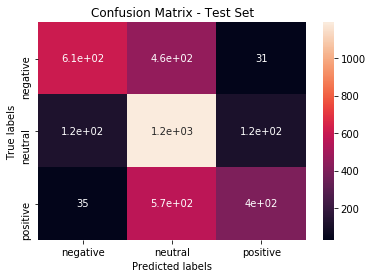

In [105]:
train_pred, test_pred, b_nb_model, b_nb_test_accuracy = run_model(models['Bernoulli Naive Bayes'],'Bernoulli Naive Bayes',x_train_bow,y_train,x_test_bow,y_test,le,tf_idf=False)
save_obj(b_nb_model, 'b_nb_model')

**Logistic Regression**

C:\Users\Alex\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Logistic Regression

Results on training set:
Accuracy score:  0.8702895034772764
Precision score:  [0.89878667 0.84121557 0.88597062]
Recall score:  [0.83066004 0.88739732 0.8843608 ]
F1 score:  [0.86338153 0.86368955 0.88516498]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6992076966610073
Precision score:  [0.71347678 0.63515152 0.79220779]
Recall score:  [0.62937063 0.73286713 0.71894832]
F1 score:  [0.66878981 0.68051948 0.75380228]
---------------------------------------------------------------------


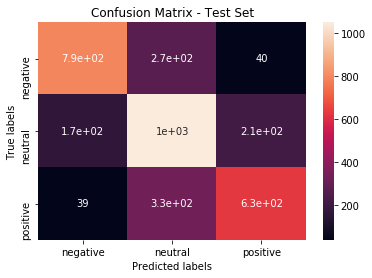

In [91]:
train_pred, test_pred, log_model, log_test_accuracy = run_model(models['Logistic Regression'],'Logistic Regression',x_train_bow,y_train,x_test_bow,y_test,le,tf_idf=False)
save_obj(log_model, 'log_model')

**K-Nearest Neighbors**

KNN

Results on training set:
Accuracy score:  0.6556040756914119
Precision score:  [0.77242789 0.56445202 0.85513078]
Recall score:  [0.43709035 0.89412611 0.54474481]
F1 score:  [0.55827315 0.69203189 0.6655278 ]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.5735710243350312
Precision score:  [0.64236902 0.49897246 0.8021148 ]
Recall score:  [0.28171828 0.84895105 0.48141432]
F1 score:  [0.39166667 0.62852705 0.60169972]
---------------------------------------------------------------------


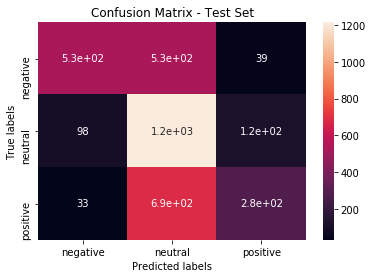

In [77]:
train_pred, test_pred, knn_model, knn_test_accuracy = run_model(models['KNN'],'KNN',x_train_bow,y_train,x_test_bow,y_test,le,tf_idf=False)
save_obj(knn_model, 'knn_model')

**Decision Tree & Bagging**

Decision Tree

Results on training set:
Accuracy score:  0.9961183891314895
Precision score:  [0.99560284 0.99440392 0.99882736]
Recall score:  [0.99630944 0.99689441 0.99493835]
F1 score:  [0.99595601 0.99564761 0.99687906]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.656479909451047
Precision score:  [0.63223938 0.6257586  0.72610837]
Recall score:  [0.65434565 0.64895105 0.6681777 ]
F1 score:  [0.6431026  0.63714384 0.69593957]
---------------------------------------------------------------------


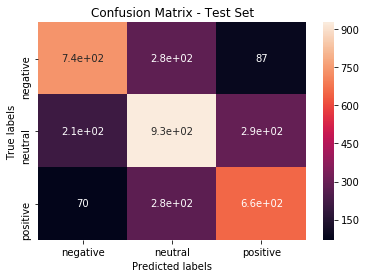

In [104]:
train_pred, test_pred, tree_model, tree_test_accuracy = run_model(models['Decision Tree'],'Decision Tree',x_train_bow,y_train,x_test_bow,y_test,le,tf_idf=False)
save_obj(tree_model, 'tree_model')

Bagging

Results on training set:
Accuracy score:  0.9939754164644994
Precision score:  [0.99544808 0.99237254 0.99470147]
Recall score:  [0.99135855 0.99496881 0.99508727]
F1 score:  [0.99339911 0.99366898 0.99489433]
---------------------------------------------------------------------
Results on test set:
Accuracy score:  0.6921335597057159
Precision score:  [0.68796592 0.65643763 0.74452555]
Recall score:  [0.64535465 0.68811189 0.73980054]
F1 score:  [0.66597938 0.67190167 0.74215553]
---------------------------------------------------------------------


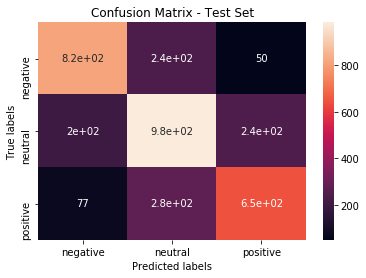

In [163]:
train_pred, test_pred, bagging_model, bagging_test_accuracy = run_model(models['Bagging'],'Bagging',x_train_bow,y_train,x_test_bow,y_test,le,tf_idf=False)
save_obj(bagging_model, 'bagging_model')

Most of the models seem to perform better than the baseline model created above, but they still have relatively low accuracies and recalls on the test set. The best performing algorithms are the logistic regression, multinomial Navier Bayes, decision tree and bagging models. They all achieve similar scores.

---

### Ensemble Model ###

A potential way of obtaining better classification performance could be to combine the results of a selection of the models trained so far in order to obtain a stronger classifier. We will try to do this by developing an ensemble of the logistic regression, multionomial Naive Bayes, decission tree and bagging models, as well as the baseline model created above.

In [39]:
#Load pre-trained models
log_model = load_obj('log_model')
m_nb_model = load_obj('m_nb_model')
tree_model = load_obj('tree_model')
bagging_model = load_obj('bagging_model')

In [40]:
#Load baseline model parameters
pos_words_selected = load_obj('pos_words_selected')
neg_words_selected = load_obj('neg_words_selected')
test_text_len = test.text.apply(lambda x: len(x.split()))

#Baseline model results and parameters passed to ensemble model
baseline_model = {'text_len':test_text_len, 'pos_words':pos_words_selected, 
                  'neg_words':neg_words_selected, 'limit':0,'weight':0.75} 

In [58]:
def calc_train_accuracies(models, train_data, train_labels, label_encoder,):
    #Function that calculates the accuracy of a list of models
    from sklearn.metrics import accuracy_score
    accuracies = []
    for model in models:
        accuracies.append(accuracy_score(train_labels, label_encoder.inverse_transform(model.predict(train_data))))
    return accuracies    

In [42]:
def ensemble_model(data, models, model_accuracies, label_encoder, baseline=None):
    #Combine results of multiple models based on their accuracy scores
    #data: bag of words dataframe, label_encoder: pretrained on training dataset (used to train ML models) 
    
    #Convert bag of words dataframe to sparse matrix 
    from scipy.sparse import csr_matrix
    data_sparse = csr_matrix(data.values)
    
    #Initialize array to hold ensembe probabilities
    ensemble_probs = np.zeros((data_sparse.shape[0],len(le.classes_)))
    
    #Compute ensemble classification probabilities: weighted sum of probabilities of each model (weighted by model's accuracy) 
    i = 0
    for model in models:         
        prob = model.predict_proba(data_sparse)
        accuracy = model_accuracies[i]
        ensemble_probs += (np.log(accuracy)/np.log(1-accuracy))*prob
        i += 1
        
    if baseline is not None:        
        #Run baseline model
        baseline_pred,baseline_prob = baseline_classifier(data, baseline['text_len'],baseline['pos_words'],
                                                          baseline['neg_words'],baseline['limit'],
                                                          show_metrics=False,plot_confusion=False,correct_labels=None)    
        
        #Convert prediction probability for each text from a single float to an array of 2 zeros and 1 float 
        #(at the correct position for computing ensemble with other models)
        baseline_pred = label_encoder.transform(baseline_pred)
        baseline_probs = np.zeros((len(baseline_prob),3))
        for i in range(len(baseline_prob)):
            j = baseline_pred[i]
            baseline_probs[i,j] = baseline_prob[i]
        
        #Add baseline model probabilities to ensemble probabilities
        ensemble_probs += baseline['weight']*baseline_probs
    
    #Normalize probs
    ensemble_probs = ensemble_probs/np.sum(ensemble_probs,axis=1)[:,None]
    
    pred = label_encoder.classes_[np.argmax(ensemble_probs,axis=1)]
    prob = np.max(ensemble_probs,axis=1)
    
    return pred, prob, ensemble_probs

In [43]:
#Select models
selected_models = [log_model,m_nb_model,bagging_model]

#Calculate model accuracies on training set (to obtain weights for ensemble model)
model_accuracies = calc_train_accuracies(selected_models, train_matrix_norm,train.sentiment.values, le)

In [44]:
#run ensemble model on test dataset
pred, prob, probs_all = ensemble_model(test_df_norm, selected_models, model_accuracies, le, baseline=baseline_model)

Results on test set:
Accuracy score: 0.70996
Precision score:  [0.7459926  0.63673469 0.80555556]
Recall score:  [0.6043956  0.76363636 0.73617407]
F1 score:  [0.66777042 0.69443561 0.76930365]
---------------------------------------------------------------------


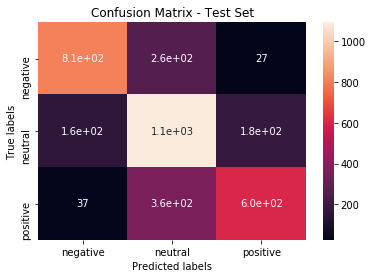

In [45]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Results on test set:')
print('Accuracy score: {:.5f}'.format(accuracy_score(test.sentiment.values, pred)))
print('Precision score: ', format(precision_score(test.sentiment.values, pred, average=None)))
print('Recall score: ', format(recall_score(test.sentiment.values, pred, average=None)))
print('F1 score: ', format(f1_score(test.sentiment.values, pred, average=None)))
print('---------------------------------------------------------------------')

#Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test.sentiment.values, pred, ['positive','neutral','negative'])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Test Set') 
ax.xaxis.set_ticklabels(le.inverse_transform([0,1,2]))
ax.yaxis.set_ticklabels(le.inverse_transform([0,1,2]))
plt.show()

The ensemble model has a slightly better performance compared to the individual classifiers. However, the improvement does not seem to be material to justify using the much more complex ensemble model.

---

### Deep Learning ###

Finally, we will switch to deep learning and try to train a long short-term memory (LSTM) network in order to classify the tweets more accurately.

A very helpful guide to LSTMs can be found here: https://towardsdatascience.com/illustrated-guide-to-lstms-and-gru-s-a-step-by-step-explanation-44e9eb85bf21

In [1]:
# Import Keras text processing functions
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

Using TensorFlow backend.


The text will first need to be converted into a sequence of integers before being passed into the LSTM. To do this we will use the Keras' Tokenizer function:

In [34]:
#combine (pre-processed) train and test datasets
all_text = list(train_text_norm.values) + list(test_text_norm.values)

In [35]:
#set maximum number of words to be kept by the tokenizer
max_words = 30913

In [36]:
#set up tokenizer
tokenizer = Tokenizer(num_words=max_words,lower=True)

In [37]:
#fit tokenizer to training texts
tokenizer.fit_on_texts(all_text)

In [38]:
#store an index of all the words that have been vectorized by the tokenizer
word_index = tokenizer.word_index

In [39]:
len(word_index)

30913

In [40]:
#convert training, test and validation texts to sequences of tokens
x_train_vec = tokenizer.texts_to_sequences(x_train.values)
x_test_vec = tokenizer.texts_to_sequences(x_test.values)
x_valid_vec = tokenizer.texts_to_sequences(x_valid.values)

Make the length of all sequences the same (by padding the start of each sequence):

In [41]:
max_length = max(x_train.apply(lambda x: len(x.split())).max(),x_test.apply(lambda x: len(x.split())).max(),x_valid.apply(lambda x: len(x.split())).max())
print('Max tweet length: {} words'.format(max_length))

Max tweet length: 33 words


In [42]:
x_train_vec = pad_sequences(x_train_vec,max_length)
x_test_vec = pad_sequences(x_test_vec,max_length)
x_valid_vec = pad_sequences(x_valid_vec,max_length)

In [43]:
x_train_vec.shape

(24732, 33)

In [44]:
x_test_vec.shape

(3534, 33)

Finally, the sentiment labels will need to be one-hot encoded in order to be used by the neural net: 

In [45]:
#one-hot encode labels
y_train_cat = pd.get_dummies(y_train)
y_valid_cat = pd.get_dummies(y_valid)
y_test_cat = pd.get_dummies(y_test)

Word embeddings are vector representations of words, which provide an effective method for measuring the similarity of words and representing it computationally. Embeddings can be learned by a neural network, but this is a difficult and time-consuming process. Luckily there are various pre-trained word embeddings available online, which can be directly imported into our LSTM. In this case, we will use the GloVe embeddings developed by Stanford, which have been pre-trained on twitter data (https://nlp.stanford.edu/projects/glove/ ). 

We will load the GloVe embeddings and obtain the embedding weights for each word in the word_index obtained above. 

Note that as this is computationally intensive, the following code has been ran once and the results were stored in a .pkl file so that they can be loaded every time the notebook is used. This is why the code in the cells below is commented out.

In [55]:
#Load GloVe embeddings
# f = open('glove.twitter.27B.100d.txt',"r", encoding="utf-8")
# count = 0
# for line in f:
#     count+=1
# f.close()
# print('Number of words in embedding:', count)

In [ ]:
#Store pre-trained embeddings in a dictionary
# i=0
# embeddings_index = dict()
# f = open('glove.twitter.27B.100d.txt',"r", encoding="utf-8")
# for line in f:
#     values = line.split()
#     word = values[0]
#     if word in list(word_index.keys()): 
#         coefs = np.asarray(values[1:], dtype='float32')
#         embeddings_index[word] = coefs
#     print('{}/{}'.format(i,count))
#     i+=1
# f.close()
# print('Loaded %s word vectors.' % len(embeddings_index))

In [186]:
#Save dictionary to a .pkl file
#save_obj(embeddings_index,'pre_embeddings_100_all')

In [50]:
#Load embeddings dict
embeddings_index = load_obj('pre_embeddings_100_all')

In [51]:
#Create a weight matrix for words in training and test docs
embedding_matrix = np.zeros((len(word_index), 100))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [52]:
embedding_matrix.shape

(30913, 100)

In [53]:
#Save embeddings matrix to a .pkl file
# save_obj(embedding_matrix,'pre_embeddings_100')

In [54]:
#Load embeddings matrix 
#embedding_matrix = load_obj('pre_embeddings_100')

We will now define the LSTM's architecture:

(Note that the following network structure has been chosen after testing a range of alternative options.)

In [55]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.layers import SpatialDropout1D, Dropout

model = Sequential()
#model.add(Embedding(max_words, 25, input_length=x_train.shape[1])) #Embedding layer if embeddings were to be learned by the LSTM
model.add(Embedding(max_words, 100, weights=[embedding_matrix], input_length=x_train_vec.shape[1],trainable=False)) #input pre-trained embeddings
model.add(SpatialDropout1D(0.25))
model.add(LSTM(150,return_sequences=True,dropout=0.25, recurrent_dropout=0.25))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(150,return_sequences=True,dropout=0.25, recurrent_dropout=0.25))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(150,return_sequences=False,dropout=0.25, recurrent_dropout=0.25))

model.add(Dense(y_train_cat.shape[1], activation='softmax'))

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 33, 100)           3091300   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 33, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 33, 150)           150600    
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 33, 150)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 33, 150)           180600    
_________________________________________________________________
spatial_dropout1d_3 (

Let's now train the LSTM. We will use the Adam optimizer with a learning rate of 0.01 and train the neural network for a maximum of 25 epochs. Early stopping will be used to stop the training if performance degrades after a certain number of epochs, in order to avoid overfitting. 

In [56]:
#Callback to plot loss while training
from plot_learning import PlotLearning
plot_learning = PlotLearning()

In [57]:
from keras.optimizers import Adam
opt = Adam(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

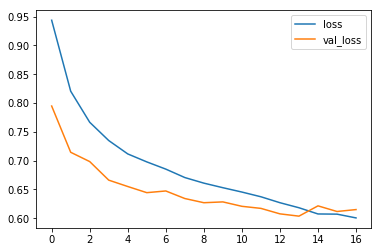

In [58]:
from keras.callbacks import EarlyStopping

epochs = 25
batch_size = 64

hist = model.fit(x_train_vec, y_train_cat, epochs=epochs, batch_size=batch_size, validation_data=[x_valid_vec,y_valid_cat], callbacks=[plot_learning,EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)], verbose=0)
#validation_data=[x_valid_vec,y_valid_cat]
#callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)]


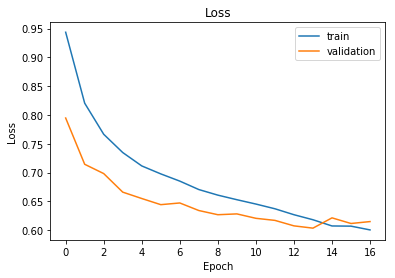

In [59]:
plt.title('Loss')
plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

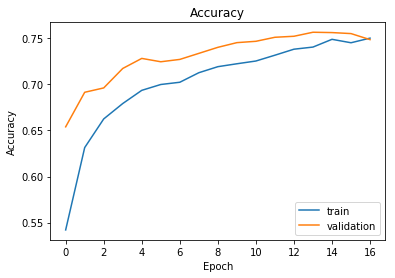

In [60]:
plt.title('Accuracy')
plt.plot(hist.history['acc'], label='train')
plt.plot(hist.history['val_acc'], label='validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [66]:
#Save the trained LSTM to a .pkl file
save_obj(model,'lstm_model')

In [38]:
#Load trained LSTM
model = load_obj('lstm_model')

Now that the LSTM is trained on the training data, let's evaluate it's performance on the test dataset:

In [54]:
#Test on test set
pred = model.predict(x_test_vec)

In [55]:
#Convert predictions from numerical to the classes' names
label_dict = {0: 'negative', 1: 'neutral', 2: 'positive'}
pred = [label_dict[pred_i] for pred_i in np.argmax(pred,axis=1)]

Results on test set:
Accuracy score: 0.76542
Precision score:  [0.72876712 0.73516949 0.84652981]
Recall score:  [0.7972028  0.72797203 0.78513146]
F1 score:  [0.76145038 0.73155306 0.81467545]
---------------------------------------------------------------------


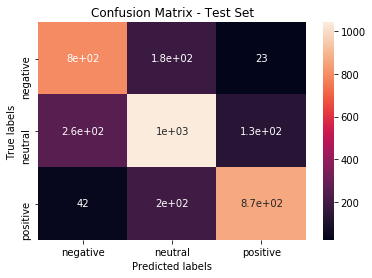

In [57]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
print('Results on test set:')
print('Accuracy score: {:.5f}'.format(accuracy_score(y_test, pred)))
print('Precision score: ', format(precision_score(y_test, pred, average=None)))
print('Recall score: ', format(recall_score(y_test, pred, average=None)))
print('F1 score: ', format(f1_score(y_test, pred, average=None)))
print('---------------------------------------------------------------------')

#Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test, pred, ['negative','neutral','positive'])

ax= plt.subplot()
sns.heatmap(cm, annot=True, ax = ax)
ax.set_xlabel('Predicted labels')
ax.set_ylabel('True labels')
ax.set_title('Confusion Matrix - Test Set') 
ax.xaxis.set_ticklabels(['negative','neutral','positive'])
ax.yaxis.set_ticklabels(['negative','neutral','positive'])
plt.show()

The LSTM performs better than all the previously tested models on this classification task. It has an accuracy of 76% on the test set, with recall, precission and F1 scores of more than 70% for all three sentiment classes. 

The main confusion in the model's predictions seems to be between negative and neutral tweets. Arround 260 tweets with neutral sentiment have been predicted as having a negative sentiment while 180 tweets with negative sentiments have been classified as neutral. Let's see some examples of misclassified tweets:

In [58]:
predictions = pd.DataFrame(test.text)
predictions['true_class'] = test.sentiment
predictions['pred_class'] = pred

Neutral tweets incorrectly classified as negative:

In [77]:
predictions[(predictions.true_class=='neutral')&(predictions.pred_class=='negative')].sample().text.values[0]

'missin the #ia2009 guys really'

Negative tweets incorrectly classified as neutral:

In [80]:
predictions[(predictions.true_class=='negative')&(predictions.pred_class=='neutral')].sample().text.values[0]

'i wear a lot of white  http://tinyurl.com/dlbltg'

Neutral tweets incorrectly classified as positive:

In [84]:
predictions[(predictions.true_class=='neutral')&(predictions.pred_class=='positive')].sample().text.values[0]

'Yay got the Internet on my itouch working'

Positive tweets incorrectly classified as neutral:

In [86]:
predictions[(predictions.true_class=='positive')&(predictions.pred_class=='neutral')].sample().text.values[0]

' - ummmm. no comment. LOL. I actually have not watched GH in about a week.'

In [71]:
predictions[(predictions.true_class!=predictions.pred_class)].to_csv('test_check.csv')

It can be seen from the above examples that in some cases the sentiment predicted by the LSTM seems more reasonable than that assigned by humans when creating the test set. For example, 'missin the #ia2009...' could have easily been a negative tweet, while 'Yay got the Internet on my itouch working' seems to be more positive than neutral. Therefore, the labelling of the test dataset may have errors. If that's the case the sentiment classification performance of our LSTM may be even better than what was found above.

---

In conclusion, a number of different approaches ranging from simple to more complex models have been tested on this text classification task. The LSTM network trained using pre-trained word embeddings had the best performance on the test dataset. Further optimization of the LSTM and additional pre-processing of the text could result in even better results.